In [1]:
## 全局变量   
sequence_length=16 # 序列长度
num_classes=69 # 事件类型种类
input_size = 1          
hidden_size = 16         
num_layers = 2
lr=0.01

num_epochs=100
## 

In [2]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong']
mpl.rcParams['axes.unicode_minus'] = False

def loadData():
    data = pd.read_csv('test_data.csv')
    sequences = data.iloc[:, :15].values
    labels = data.iloc[:, 15].values

    # 划分训练集和测试集
    train_sequences, test_sequences, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)

    # 划分训练集和验证集
    train_sequences, val_sequences, train_labels, val_labels = train_test_split(train_sequences, train_labels, test_size=0.25, random_state=42)

    # 创建 TensorDataset 对象
    train_dataset = TensorDataset(torch.from_numpy(train_sequences).to(torch.float32), torch.from_numpy(train_labels).to(torch.long))
    val_dataset = TensorDataset(torch.from_numpy(val_sequences).to(torch.float32), torch.from_numpy(val_labels).to(torch.long))
    test_dataset = TensorDataset(torch.from_numpy(test_sequences).to(torch.float32), torch.from_numpy(test_labels).to(torch.long))

    # 创建 DataLoader 对象
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = loadData()

In [3]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # 前向传播LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # 解码最后一个时间步的隐藏状态
        out = self.fc(out[:, -1, :])
        return out

# 实例化模型
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


Iteration: 0 loss 2.887833595275879


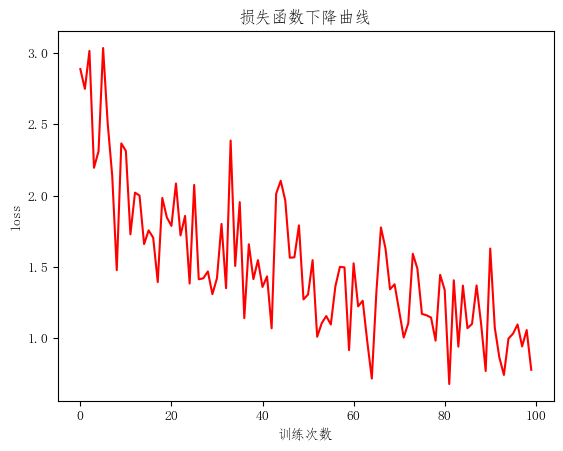

In [4]:
# 训练模型
def train(model, train_loader, criterion, optimizer, num_epochs):
    l = []
    for epoch in range(num_epochs):
        for i, (sequences, labels) in enumerate(train_loader):
            sequences = sequences.reshape(-1, sequence_length-1, input_size)
            # 前向传播
            outputs = model(sequences)
            # print(outputs.shape)
            # print(labels.shape)
            loss = criterion(outputs, labels)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0:
            print("Iteration: {} loss {}".format(epoch, loss.item()))
        l.append(loss.item())
    # 绘制损失函数
    plt.plot(l,'r')
    plt.xlabel('训练次数')
    plt.ylabel('loss')
    plt.title('损失函数下降曲线')
    plt.show()

train(model, train_loader, criterion, optimizer, num_epochs)


In [5]:
# 验证模型
def validate(model, val_loader, criterion):
    with torch.no_grad():
        correct = 0
        total = 0
        for sequences, labels in val_loader:
            sequences = sequences.reshape(-1, sequence_length-1, input_size)
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print('Accuracy: {} %'.format(accuracy))

validate(model, val_loader, criterion)

Accuracy: 56.91699604743083 %


tensor([[[ 5.],
         [10.],
         [31.],
         [ 0.],
         [19.],
         [50.],
         [65.],
         [53.],
         [13.],
         [37.],
         [ 7.],
         [59.],
         [51.],
         [39.],
         [45.],
         [18.]]])
[8.8059052e-04 1.1893399e-01 2.8038310e-06 1.2398360e-02 5.3568412e-02
 3.5768781e-02 6.0361646e-02 7.8285047e-06 2.6496525e-03 2.4162327e-06
 1.7176644e-04 2.7434982e-05 4.6084144e-05 2.7887279e-05 3.5949858e-04
 1.5678764e-06 3.9199663e-06 3.6470078e-06 2.0790469e-06 3.3747604e-01
 1.7812378e-04 2.7255758e-04 2.7969648e-04 3.8370068e-05 2.6930177e-06
 1.0322721e-01 1.9206122e-06 1.4303186e-03 3.0983396e-05 1.6471777e-06
 2.3759703e-06 2.6306466e-06 1.2363245e-03 1.3452959e-07 6.5261237e-03
 1.1570535e-01 5.9299874e-03 3.5294253e-04 1.3793006e-03 4.8619698e-04
 1.5873244e-05 2.6334931e-06 4.5522866e-06 1.6830551e-06 8.1145978e-03
 3.2325126e-02 4.1482677e-03 3.0183378e-03 8.1135958e-02 3.0064899e-03
 8.0093537e-03 6.5047905e-05 2.6

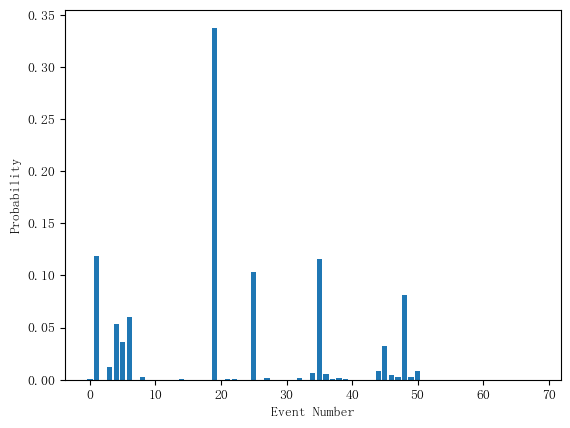

In [6]:
def random(model):
    # 预测下一次事件各个编号的出现概率
    current_sequence = np.random.randint(num_classes, size=(1, sequence_length, 1))
    current_sequence = torch.tensor(current_sequence, dtype=torch.float32)
    print(current_sequence)
    outputs = model(current_sequence)
    probabilities = nn.functional.softmax(outputs, dim=1)
    probabilities = probabilities.detach().numpy().flatten()
    # probabilities = torch.softmax(outputs, dim=1).squeeze()
    print(probabilities)

    # 可视化结果
    plt.bar(range(len(probabilities)), probabilities)
    # plt.xticks(range(len(probabilities)),  rotation='270')
    plt.xlabel('Event Number')
    plt.ylabel('Probability')
    plt.show()

random(model)

In [ ]:
import matplotlib.pyplot as plt

def predict(model, sequence):
    with torch.no_grad():
        # 将序列转换为张量
        sequence = torch.tensor(sequence).float().unsqueeze(0)

        # 前向传播
        outputs = model(sequence)
        
        # 计算概率
        probabilities = torch.softmax(outputs, dim=1).squeeze()
        return probabilities

# 预测序列 [1, 2, 3] 的下一个事件编号的概率
sequence = [[1], [2], [3]]
probabilities = predict(model, sequence)
print(probabilities)
# 可视化结果
plt.bar(range(len(probabilities)), probabilities)
plt.xlabel('Event Number')
plt.ylabel('Probability')
plt.show()